In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from selectinf.base import selected_targets, restricted_estimator
import copy

import regreg.api as rr

from selectinf.group_lasso_query import (group_lasso, split_group_lasso)

from selectinf.Simulation.instance import logistic_group_instance

from selectinf.Simulation.test_logistic_group_lasso import (calculate_F1_score,
                                                            naive_inference,
                                                            randomization_inference,
                                                            randomization_inference_fast,
                                                            split_inference, data_splitting)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_operating_characteristics(data):
    """
    Plot box plots for each operating characteristic ('coverage rate', 'avg length', 'F1 score'),
    across proportions and methods.
    
    Parameters:
    data : dict
        A dictionary where each key is a tuple (p, m) of (proportion, method), and the value is a dictionary
        with keys 'coverage rate', 'avg length', and 'F1 score', and values are lists of results from simulations.
    """
    
    # First, we need to restructure the data into a DataFrame
    records = []
    
    for (p, m), metrics in data.items():
        for metric_name, metric_values in metrics.items():
            for value in metric_values:
                records.append({'proportion': p, 'method': m, 'metric': metric_name, 'value': value})
    
    df = pd.DataFrame(records)
    
    # Set up the figure with three panels for each metric
    fig, axes = plt.subplots(1, 6, figsize=(24, 6))
    metrics = ['coverage rate', 'avg length', 'F1 score', '|E|', "precision", "recall"]
    
    # Plot boxplots for each metric in a separate panel
    for i, metric in enumerate(metrics):
        sns.boxplot(
            data=df[df['metric'] == metric],
            x='proportion', 
            y='value', 
            hue='method', 
            ax=axes[i]
        )
        axes[i].set_title(metric)
        axes[i].set_ylabel('Value')
        axes[i].set_xlabel('Proportion')
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# data = {
#     (0.1, 'method1'): {'coverage rate': [0.9, 0.85], 'avg length': [1.2, 1.3], 'F1 score': [0.75, 0.8]},
#     (0.1, 'method2'): {'coverage rate': [0.8, 0.82], 'avg length': [1.4, 1.5], 'F1 score': [0.7, 0.72]},
#     (0.2, 'method1'): {'coverage rate': [0.95], 'avg length': [1.1], 'F1 score': [0.78]},
#     ...
# }
# plot_operating_characteristics(data)


In [8]:
def comparison_logistic(range, weight_const=1.):
    """
        Compare to R randomized lasso
        """
    p = 20
    signal_fac = 1
    rho = 0.
    proportion = 0.5
    level = 0.90

    # Operating characteristics
    oper_char = {}
    oper_char["coverage rate"] = []
    oper_char["avg length"] = []
    oper_char["F1 score"] = []
    oper_char["|E|"] = []
    oper_char["precision"] = []
    oper_char["recall"] = []
    
    n_s = [100, 200, 350, 500]
    inf_nums = {n: 0 for n in n_s}
    methods = ["MLE", "Data splitting", "Naive"]
    dict_return = {(n, m): copy.deepcopy(oper_char) for n in n_s for m in methods}
    
    for n in n_s:
        for i in range:
            print(i, "th simulation")
            np.random.seed(i)

            inst, const, const_split = logistic_group_instance, group_lasso.logistic, \
                                       split_group_lasso.logistic
            signal = np.sqrt(signal_fac * 2 * np.log(p))
            signal_str = str(np.round(signal, decimals=2))

            while True:  # run until we get some selection
                groups = np.arange(5).repeat(4)
                X, Y, beta = inst(n=n,
                                  p=p,
                                  signal=signal,
                                  sgroup=0,
                                  groups=groups,
                                  ndiscrete=5,
                                  nlevels=5,
                                  sdiscrete=2,  # s-3, # How many discrete rvs are not null
                                  equicorrelated=False,
                                  rho=rho,
                                  random_signs=True)[:3]
                print(beta)
                # print(X)

                n, p = X.shape

                # MLE inference
                coverage, length, beta_target, nonzero, conf_low, conf_up = \
                    randomization_inference_fast(X=X, Y=Y, n=n, p=p, 
                                                 proportion=proportion,
                                                 beta=beta, groups=groups,
                                                 weight_frac=weight_const)
                MLE_E0 = (coverage is None)
                    
                rank_def, coverage_ds, lengths_ds, conf_low_ds, conf_up_ds, nonzero_ds, beta_target_ds = \
                    data_splitting(X=X, Y=Y, n=n, p=p, beta=beta, 
                                   groups=groups,
                                   proportion=proportion, level=0.9,
                                   count_rank_deficiency=True,
                                   #weight_frac=weight_const*np.sqrt(proportion))
                                   weight_frac=weight_const)


                # naive inference
                coverage_naive, lengths_naive, nonzero_naive, conf_low_naive, conf_up_naive, \
                beta_target_naive = \
                    naive_inference(X=X, Y=Y, groups=groups,
                                    beta=beta, const=const,
                                    n=n, level=level,
                                    weight_frac=weight_const)
                #noselection = (coverage_naive is None)
                naive_E0 = (coverage_naive is None)

                if not MLE_E0:
                    print("Beta != 0:", (beta != 0))
                    print("MLE != 0:", nonzero)
                    precision = ((beta != 0) * nonzero).sum() / nonzero.sum()
                    recall = ((beta != 0) * nonzero).sum() / (beta != 0).sum()
                    print("F1 MLE:")
                    #print("MLE |E|:" , nonzero.sum())
                    dict_return[(n, 'MLE')]["|E|"].append(nonzero.sum())
                    F1 = calculate_F1_score(beta, selection=nonzero)
                    dict_return[(n, 'MLE')]["F1 score"].append(F1)
                    # MLE coverage
                    dict_return[(n, 'MLE')]["coverage rate"].append(np.mean(coverage))
                    dict_return[(n, 'MLE')]["avg length"].append(np.mean(length))
                    dict_return[(n, 'MLE')]["precision"].append(precision)
                    dict_return[(n, 'MLE')]["recall"].append(recall)
                else:
                    print("MLE noselection")
                    dict_return[(n, 'MLE')]["F1 score"].append(0)
                    dict_return[(n, 'MLE')]["|E|"].append(0)
                    dict_return[(n, 'MLE')]["precision"].append(0)
                    dict_return[(n, 'MLE')]["recall"].append(0)
                        
                if not naive_E0:
                    precision_naive = ((beta != 0) * nonzero_naive).sum() / nonzero_naive.sum()
                    recall_naive = ((beta != 0) * nonzero_naive).sum() / (beta != 0).sum()
                    #print("Naive |E|:" , nonzero_naive.sum())
                    print("F1 naive:")
                    F1_naive = calculate_F1_score(beta, selection=nonzero_naive)
                    dict_return[(n, 'Naive')]["|E|"].append(nonzero_naive.sum())
                    dict_return[(n, 'Naive')]["coverage rate"].append(np.mean(coverage_naive))
                    dict_return[(n, 'Naive')]["avg length"].append(np.mean(lengths_naive))
                    dict_return[(n, 'Naive')]["F1 score"].append(F1_naive)
                    dict_return[(n, 'Naive')]["precision"].append(precision_naive)
                    dict_return[(n, 'Naive')]["recall"].append(recall_naive)
                else:
                    print("Naive noselection")
                    dict_return[(n, 'Naive')]["F1 score"].append(0)
                    dict_return[(n, 'Naive')]["|E|"].append(0)
                    dict_return[(n, 'Naive')]["precision"].append(0)
                    dict_return[(n, 'Naive')]["recall"].append(0)
                    
                if not rank_def and coverage_ds is not None:
                    #print("DS |E|:" , nonzero_ds.sum())
                    precision_ds = ((beta != 0) * nonzero_ds).sum() / nonzero_ds.sum()
                    recall_ds = ((beta != 0) * nonzero_ds).sum() / (beta != 0).sum()
                    # If made some selection and is not rank deficient
                    print("F1 ds:")
                    F1_ds = calculate_F1_score(beta, selection=nonzero_ds)
                    dict_return[(n, 'Data splitting')]["|E|"].append(nonzero_ds.sum())
                    dict_return[(n, 'Data splitting')]["F1 score"].append(F1_ds)
                    # Data splitting coverage
                    dict_return[(n, 'Data splitting')]["coverage rate"].append(np.mean(coverage_ds))
                    dict_return[(n, 'Data splitting')]["avg length"].append(np.mean(lengths_ds))
                    dict_return[(n, 'Data splitting')]["precision"].append(precision_ds)
                    dict_return[(n, 'Data splitting')]["recall"].append(recall_ds)
                elif rank_def:
                    print("DS rank deficient")
                    print("F1 ds:")
                    # If we encounter rank deficiency but made selections
                    F1_ds = calculate_F1_score(beta, selection=nonzero_ds)
                    dict_return[(n, 'Data splitting')]["F1 score"].append(F1_ds)
                    dict_return[(n, 'Data splitting')]["|E|"].append(nonzero_ds.sum())
                    dict_return[(n, 'Data splitting')]["precision"].append(precision_ds)
                    dict_return[(n, 'Data splitting')]["recall"].append(recall_ds)
                    inf_nums[n] += 1
                    
                    # Data splitting coverage
                else:
                    print("DS no selection")
                    # If we encounter zero selections
                    dict_return[(n, 'Data splitting')]["F1 score"].append(0)
                    dict_return[(n, 'Data splitting')]["|E|"].append(0)
                    dict_return[(n, 'Data splitting')]["precision"].append(0)
                    dict_return[(n, 'Data splitting')]["recall"].append(0)

                break  # Go to next iteration if we have some selection

    print("task done")
    return dict_return, inf_nums

In [35]:
dict_vary_n, n_infty_vary_n = comparison_logistic(range(0,500), weight_const=1)

0 th simulation
[ 0.          0.          0.          0.         -0.24477468  0.24477468
 -0.24477468  0.24477468  0.          0.          0.          0.
  0.          0.          0.          0.         -0.24477468  0.24477468
 -0.24477468  0.24477468]
MLE l1 weights: {0: 1.7308183826022852, 1: 1.7308183826022852, 2: 1.7308183826022852, 3: 1.7308183826022852, 4: 1.7308183826022852}
Naive l1 weights: {0: 1.2238734153404083, 1: 1.2238734153404083, 2: 1.2238734153404083, 3: 1.2238734153404083, 4: 1.2238734153404083}
Beta != 0: [False False False False  True  True  True  True False False False False
 False False False False  True  True  True  True]
MLE != 0: [ True  True  True  True False False False False False False False False
 False False False False False False False False]
F1 MLE:
precision: 0.0 recall 0.0
F1 naive:
precision: 1.0 recall 0.5
F1 ds:
precision: 1.0 recall 0.5
1 th simulation
[ 0.          0.          0.          0.         -0.24477468 -0.24477468
  0.24477468 -0.244774

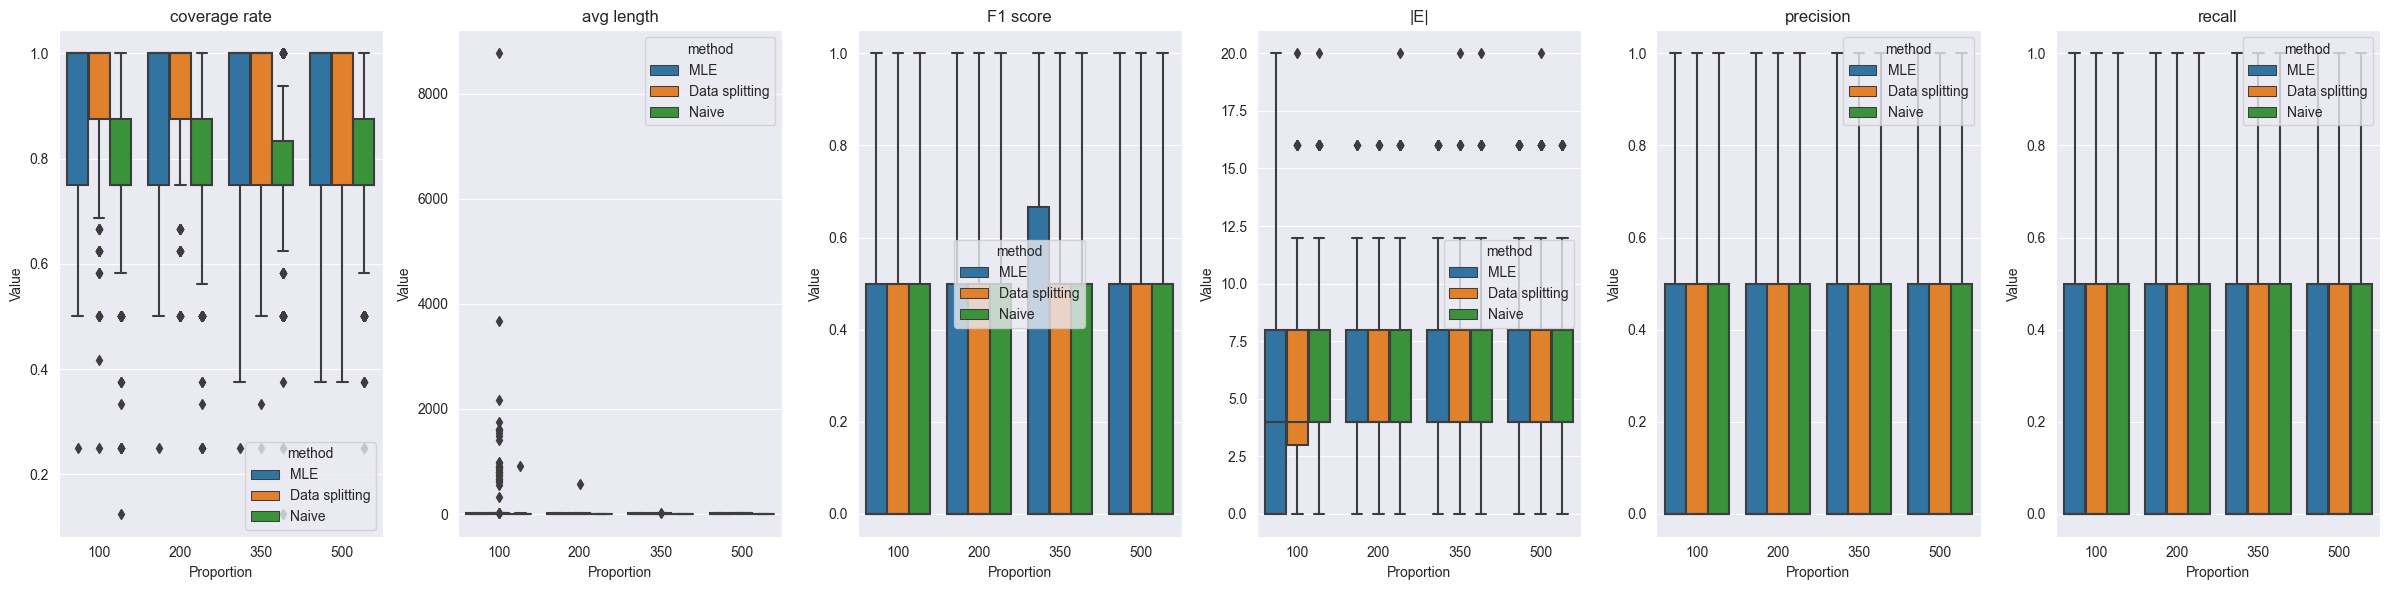

In [36]:
plot_operating_characteristics(dict_vary_n)

In [37]:
mean_dict_vary_n = {}
mean_dict_vary_n["method"] = []
mean_dict_vary_n["n"] = []
mean_dict_vary_n["coverage rate"] = []
mean_dict_vary_n["avg length"] = []
mean_dict_vary_n["F1 score"] = []
for (n, m) in dict_vary_n.keys():
    print(n, m)
    i = 0
    mean_dict_vary_n["method"].append(m)
    mean_dict_vary_n["n"].append(n)
    for k in dict_vary_n[(n,m)].keys():
        print(k, ":", np.mean(dict_vary_n[(n,m)][k]))
        mean_dict_vary_n[k].append(np.mean(dict_vary_n[(n,m)][k]))
        i += 1
        if i == 3:
            break

100 MLE
coverage rate : 0.9017922374429225
avg length : 8.939603720440092
F1 score : 0.2444095238095238
100 Data splitting
coverage rate : 0.9203052273540996
avg length : 108.53221910033858
F1 score : 0.27119134199134204
100 Naive
coverage rate : 0.7781964869281047
avg length : 9.416070685451972
F1 score : 0.28417922077922075
200 MLE
coverage rate : 0.9005922165820643
avg length : 8.983750483818692
F1 score : 0.257
200 Data splitting
coverage rate : 0.9113020833333334
avg length : 11.258191692446644
F1 score : 0.2725878787878788
200 Naive
coverage rate : 0.7700084602368866
avg length : 6.877618529394802
F1 score : 0.25432467532467534
350 MLE
coverage rate : 0.8824555837563451
avg length : 9.066861735757527
F1 score : 0.2754666666666667
350 Data splitting
coverage rate : 0.891884328358209
avg length : 9.5095219380951
F1 score : 0.2751489177489177
350 Naive
coverage rate : 0.7519547325102881
avg length : 6.71538856580784
F1 score : 0.2815246753246753
500 MLE
coverage rate : 0.90381768189

In [38]:
df_n = pd.DataFrame(mean_dict_vary_n)

In [39]:
# Step 1: Group by 'proportion' and 'method', and calculate mean values for each metric
grouped = df_n.groupby(['n', 'method']).mean().reset_index()

# Step 2: Pivot the DataFrame to get methods in separate columns for each metric
pivoted = grouped.pivot(index='n', columns='method')

# Step 3: Flatten the MultiIndex columns for better readability
pivoted.columns = [' '.join(col).strip() for col in pivoted.columns.values]

# Step 4: Reorder columns to match the desired table format
final_df_n = pivoted[['coverage rate Naive', 'coverage rate Data splitting', 'coverage rate MLE', 
                    'F1 score Naive', 'F1 score Data splitting', 'F1 score MLE',
                    'avg length Data splitting', 'avg length MLE']]


## Proper scaling of intervals
The confidence intervals we now construct are for parameters $\sqrt{n}\widehat{\beta}_n$. However, to make the intervals represent confidence intervals for the $O(1)$ parameters $\beta_M$, we need to properly scale all confidence intervals by a multiplicative factor of $\sqrt{1/n}$.

In [40]:
n = final_df_n.index

In [41]:
final_df_n_scaled = final_df_n.copy()

In [42]:
for i in range(len(n)):
    final_df_n_scaled["avg length Data splitting"][n[i]] /= np.sqrt(n[i])
    final_df_n_scaled["avg length MLE"][n[i]] /= np.sqrt(n[i])

In [43]:
final_df_n_scaled

,coverage rate Naive,coverage rate Data splitting,coverage rate MLE,F1 score Naive,F1 score Data splitting,F1 score MLE,avg length Data splitting,avg length MLE
n,,,,,,,,
100,0.778196,0.920305,0.901792,0.284179,0.271191,0.244410,10.853222,0.893960
200,0.770008,0.911302,0.900592,0.254325,0.272588,0.257000,0.796074,0.635247
350,0.751955,0.891884,0.882456,0.281525,0.275149,0.275467,0.508305,0.484644
500,0.782278,0.900177,0.903818,0.263933,0.261791,0.247200,0.428133,0.409697


In [44]:
final_df_n_scaled.round(3).to_csv('vary_n_signal1.csv')

# Vary split proportion

In [60]:
def comparison_logistic_varyprop(range, weight_const=1.):
    """
        Compare to R randomized lasso
        """
    n = 200
    p = 20
    signal_fac = 100
    rho = 0
    level = 0.90

    # Operating characteristics
    oper_char = {}
    oper_char["coverage rate"] = []
    oper_char["avg length"] = []
    oper_char["F1 score"] = []
    oper_char["|E|"] = []
    oper_char["precision"] = []
    oper_char["recall"] = []
    
    props = [0.5, 0.6, 0.7, 0.8]
    ds_long_int_count = {p: 0 for p in props}
    methods = ["MLE", "Data splitting", "Naive"]
    
    dict_return = {(p, m): copy.deepcopy(oper_char) for p in props for m in methods}
    
    #for n in [100, 200, 350, 500]:
    for proportion in props:#[0.5, 0.6, 0.7, 0.8]:
        #for proportion in [0.3, 0.4, 0.5, 0.6, 0.7]:  # [0.01, 0.03, 0.06, 0.1]:
            for i in range:
                print(i, "th simulation")
                np.random.seed(10000+i)
    
                inst, const, const_split = logistic_group_instance, group_lasso.logistic, \
                                           split_group_lasso.logistic
                signal = np.sqrt(signal_fac * 2 * np.log(p))
                signal_str = str(np.round(signal, decimals=2))
    
                while True:  # run until we get some selection
                    groups = np.arange(5).repeat(4)
                    X, Y, beta = inst(n=n,
                                      p=p,
                                      signal=signal,
                                      sgroup=0,
                                      groups=groups,
                                      ndiscrete=5,
                                      nlevels=5,
                                      sdiscrete=2,  # s-3, # How many discrete rvs are not null
                                      scale=True,
                                      equicorrelated=False,
                                      rho=rho,
                                      random_signs=True)[:3]
                    # print(X)
    
                    n, p = X.shape
                    
                    # MLE inference
                    coverage, length, beta_target, nonzero, conf_low, conf_up = \
                        randomization_inference_fast(X=X, Y=Y, n=n, p=p, 
                                                     proportion=proportion,
                                                     beta=beta, groups=groups,
                                                     #weight_frac=weight_const)
                                                     weight_frac=weight_const)
                    MLE_E0 = (coverage is None)
                    
                    rank_def, coverage_ds, lengths_ds, conf_low_ds, conf_up_ds, nonzero_ds, beta_target_ds = \
                        data_splitting(X=X, Y=Y, n=n, p=p, beta=beta, 
                                       groups=groups,
                                       proportion=proportion, level=0.9,
                                       count_rank_deficiency=True,
                                       #weight_frac=weight_const*np.sqrt(proportion))
                                       weight_frac=weight_const)
                    
                    # naive inference
                    coverage_naive, lengths_naive, nonzero_naive, conf_low_naive, conf_up_naive, \
                    beta_target_naive = \
                        naive_inference(X=X, Y=Y, groups=groups,
                                        beta=beta, const=const,
                                        n=n, level=level,
                                        weight_frac=weight_const)
                    #noselection = (coverage_naive is None)
                    naive_E0 = (coverage_naive is None)

                    if not MLE_E0:
                        print("Beta != 0:", (beta != 0))
                        print("MLE != 0:", nonzero)
                        precision = ((beta != 0) * nonzero).sum() / nonzero.sum()
                        recall = ((beta != 0) * nonzero).sum() / (beta != 0).sum()
                        print("F1 MLE:")
                        #print("MLE |E|:" , nonzero.sum())
                        dict_return[(proportion, 'MLE')]["|E|"].append(nonzero.sum())
                        F1 = calculate_F1_score(beta, selection=nonzero)
                        dict_return[(proportion, 'MLE')]["F1 score"].append(F1)
                        # MLE coverage
                        dict_return[(proportion, 'MLE')]["coverage rate"].append(np.mean(coverage))
                        dict_return[(proportion, 'MLE')]["avg length"].append(np.mean(length))
                        dict_return[(proportion, 'MLE')]["precision"].append(precision)
                        dict_return[(proportion, 'MLE')]["recall"].append(recall)
                    else:
                        print("MLE noselection")
                        dict_return[(proportion, 'MLE')]["F1 score"].append(0)
                        dict_return[(proportion, 'MLE')]["|E|"].append(0)
                        dict_return[(proportion, 'MLE')]["precision"].append(0)
                        dict_return[(proportion, 'MLE')]["recall"].append(0)
                        
                    if not naive_E0:
                        precision_naive = ((beta != 0) * nonzero_naive).sum() / nonzero_naive.sum()
                        recall_naive = ((beta != 0) * nonzero_naive).sum() / (beta != 0).sum()
                        #print("Naive |E|:" , nonzero_naive.sum())
                        print("F1 naive:")
                        F1_naive = calculate_F1_score(beta, selection=nonzero_naive)
                        dict_return[(proportion, 'Naive')]["|E|"].append(nonzero_naive.sum())
                        dict_return[(proportion, 'Naive')]["coverage rate"].append(np.mean(coverage_naive))
                        dict_return[(proportion, 'Naive')]["avg length"].append(np.mean(lengths_naive))
                        dict_return[(proportion, 'Naive')]["F1 score"].append(F1_naive)
                        dict_return[(proportion, 'Naive')]["precision"].append(precision_naive)
                        dict_return[(proportion, 'Naive')]["recall"].append(recall_naive)
                    else:
                        print("Naive noselection")
                        dict_return[(proportion, 'Naive')]["F1 score"].append(0)
                        dict_return[(proportion, 'Naive')]["|E|"].append(0)
                        dict_return[(proportion, 'Naive')]["precision"].append(0)
                        dict_return[(proportion, 'Naive')]["recall"].append(0)
                        
                    if not rank_def and coverage_ds is not None:
                        #print("DS |E|:" , nonzero_ds.sum())
                        precision_ds = ((beta != 0) * nonzero_ds).sum() / nonzero_ds.sum()
                        recall_ds = ((beta != 0) * nonzero_ds).sum() / (beta != 0).sum()
                        # If made some selection and is not rank deficient
                        print("F1 ds:")
                        F1_ds = calculate_F1_score(beta, selection=nonzero_ds)
                        dict_return[(proportion, 'Data splitting')]["|E|"].append(nonzero_ds.sum())
                        dict_return[(proportion, 'Data splitting')]["F1 score"].append(F1_ds)
                        # Data splitting coverage
                        dict_return[(proportion, 'Data splitting')]["coverage rate"].append(np.mean(coverage_ds))
                        dict_return[(proportion, 'Data splitting')]["avg length"].append(np.mean(lengths_ds))
                        dict_return[(proportion, 'Data splitting')]["precision"].append(precision_ds)
                        dict_return[(proportion, 'Data splitting')]["recall"].append(recall_ds)
                        if np.mean(lengths_ds) > 100:
                            ds_long_int_count[proportion] += 1
                    elif rank_def:
                        print("DS rank deficient")
                        print("F1 ds:")
                        # If we encounter rank deficiency but made selections
                        F1_ds = calculate_F1_score(beta, selection=nonzero_ds)
                        dict_return[(proportion, 'Data splitting')]["F1 score"].append(F1_ds)
                        dict_return[(proportion, 'Data splitting')]["|E|"].append(nonzero_ds.sum())
                        dict_return[(proportion, 'Data splitting')]["precision"].append(precision_ds)
                        dict_return[(proportion, 'Data splitting')]["recall"].append(recall_ds)
                        #inf_nums[proportion] += 1
                        
                        # Data splitting coverage
                    else:
                        print("DS no selection")
                        # If we encounter zero selections
                        dict_return[(proportion, 'Data splitting')]["F1 score"].append(0)
                        dict_return[(proportion, 'Data splitting')]["|E|"].append(0)
                        dict_return[(proportion, 'Data splitting')]["precision"].append(0)
                        dict_return[(proportion, 'Data splitting')]["recall"].append(0)

                    break  # Go to next iteration if we have some selection

    #oper_char_df = pd.DataFrame.from_dict(oper_char)

    print("task done")
    return dict_return, ds_long_int_count

In [73]:
dict_vary_prop, ds_long_int_count = comparison_logistic_varyprop(range(0,500), 
                                                                 weight_const=1)

0 th simulation
MLE l1 weights: {0: 1.7025482512665657, 1: 1.7025482512665657, 2: 1.7025482512665657, 3: 1.7025482512665657, 4: 1.7025482512665657}
Naive l1 weights: {0: 1.2038834137678867, 1: 1.2038834137678867, 2: 1.2038834137678867, 3: 1.2038834137678867, 4: 1.2038834137678867}
Beta != 0: [False False False False  True  True  True  True  True  True  True  True
 False False False False False False False False]
MLE != 0: [ True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False False False]
F1 MLE:
precision: 0.6666666666666666 recall 1.0
F1 naive:
precision: 0.5 recall 0.5
F1 ds:
precision: 0.3333333333333333 recall 0.5
1 th simulation
MLE l1 weights: {0: 1.7137724239210794, 1: 1.7137724239210794, 2: 1.7137724239210794, 3: 1.7137724239210794, 4: 1.7137724239210794}
Naive l1 weights: {0: 1.211820102365102, 1: 1.211820102365102, 2: 1.211820102365102, 3: 1.211820102365102, 4: 1.211820102365102}
Beta != 0: [False False False False  True

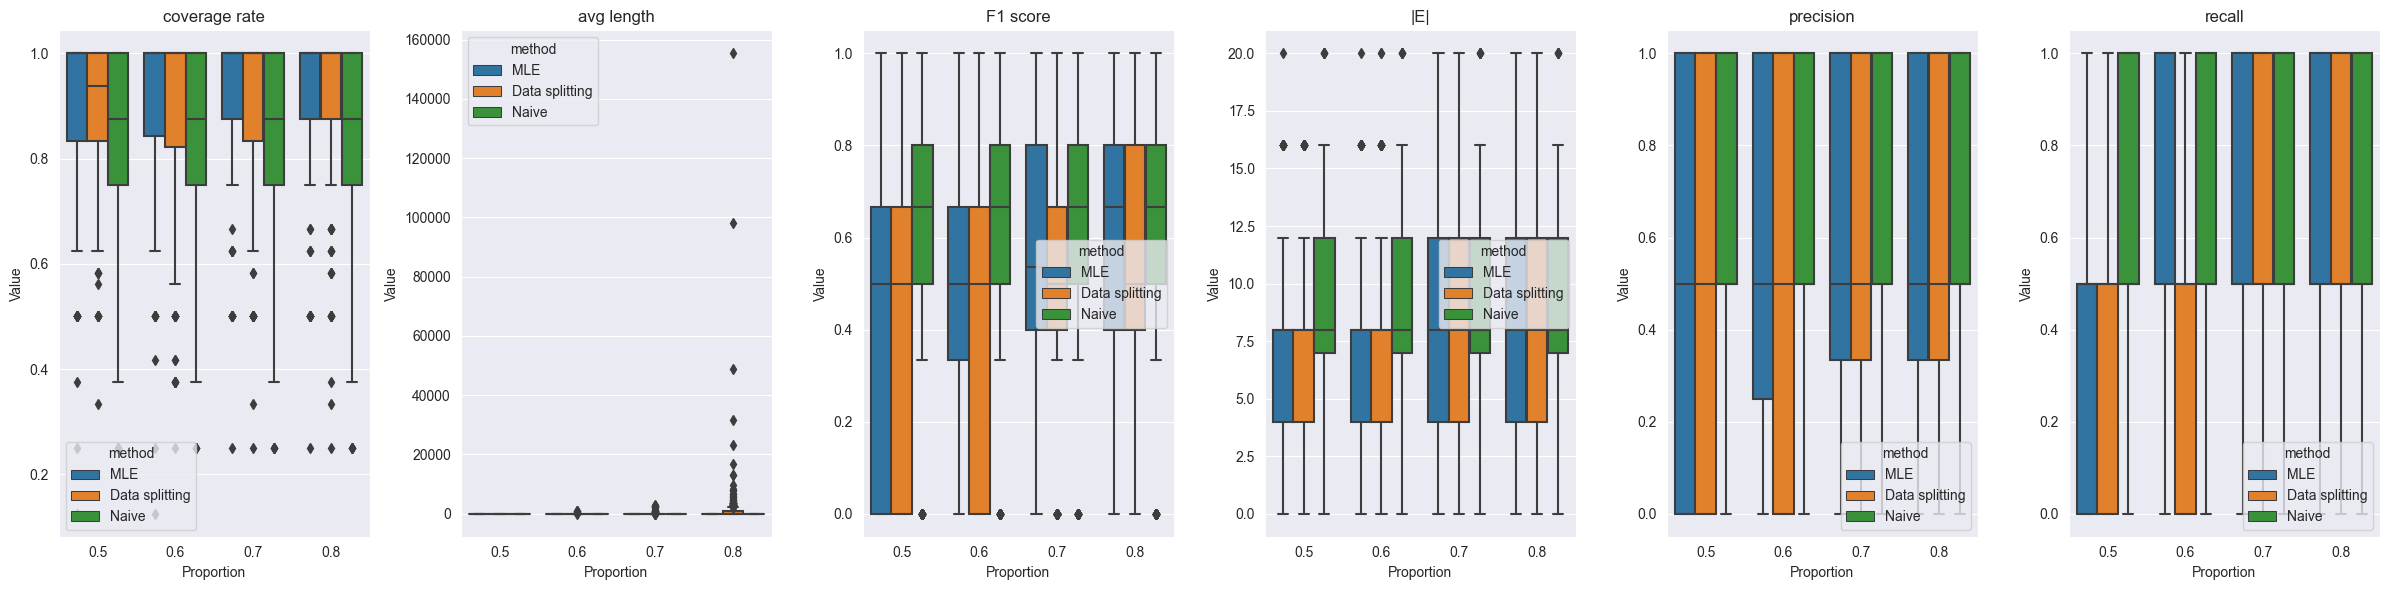

In [74]:
plot_operating_characteristics(dict_vary_prop)

In [75]:
mean_dict_vary_prop = {}
mean_dict_vary_prop["method"] = []
mean_dict_vary_prop["proportion"] = []
mean_dict_vary_prop["coverage rate"] = []
mean_dict_vary_prop["avg length"] = []
mean_dict_vary_prop["F1 score"] = []
for (p, m) in dict_vary_prop.keys():
    print(p, m)
    i = 0
    mean_dict_vary_prop["method"].append(m)
    mean_dict_vary_prop["proportion"].append(p)
    for k in dict_vary_prop[(p,m)].keys():
        print(k, ":", np.mean(dict_vary_prop[(p,m)][k]))
        mean_dict_vary_prop[k].append(np.mean(dict_vary_prop[(p,m)][k]))
        i += 1
        if i == 3:
            break

0.5 MLE
coverage rate : 0.9042120551924473
avg length : 9.398993940899794
F1 score : 0.4672761904761905
0.5 Data splitting
coverage rate : 0.8983501118568232
avg length : 10.556145945572405
F1 score : 0.43991515151515154
0.5 Naive
coverage rate : 0.8423218029350106
avg length : 7.513165639133521
F1 score : 0.5881203463203464
0.6 MLE
coverage rate : 0.9118235930735931
avg length : 10.510923107243983
F1 score : 0.4992095238095238
0.6 Data splitting
coverage rate : 0.8979841612670986
avg length : 21.304554048913214
F1 score : 0.4706069264069264
0.6 Naive
coverage rate : 0.8423218029350106
avg length : 7.513165639133521
F1 score : 0.5881203463203464
0.7 MLE
coverage rate : 0.9135372340425533
avg length : 12.08118893298909
F1 score : 0.5314190476190477
0.7 Data splitting
coverage rate : 0.9006186317321688
avg length : 70.86419135059317
F1 score : 0.49603549783549783
0.7 Naive
coverage rate : 0.8423218029350106
avg length : 7.513165639133521
F1 score : 0.5881203463203464
0.8 MLE
coverage rat

In [76]:
df_prop = pd.DataFrame(mean_dict_vary_prop)

In [77]:
# Step 1: Group by 'proportion' and 'method', and calculate mean values for each metric
grouped = df_prop.groupby(['proportion', 'method']).mean().reset_index()

# Step 2: Pivot the DataFrame to get methods in separate columns for each metric
pivoted = grouped.pivot(index='proportion', columns='method')

# Step 3: Flatten the MultiIndex columns for better readability
pivoted.columns = [' '.join(col).strip() for col in pivoted.columns.values]

# Step 4: Reorder columns to match the desired table format
final_df_vary_prop = pivoted[['coverage rate Naive', 'coverage rate Data splitting', 'coverage rate MLE', 
                    'F1 score Naive', 'F1 score Data splitting', 'F1 score MLE',
                    'avg length Data splitting', 'avg length MLE']]


## Proper scaling of intervals
The confidence intervals we now construct are for parameters $\sqrt{n}\widehat{\beta}_n$. However, to make the intervals represent confidence intervals for the $O(1)$ parameters $\beta_M$, we need to properly scale all confidence intervals by a multiplicative factor of $\sqrt{1/n}$.

In [78]:
final_df_vary_prop

,coverage rate Naive,coverage rate Data splitting,coverage rate MLE,F1 score Naive,F1 score Data splitting,F1 score MLE,avg length Data splitting,avg length MLE
proportion,,,,,,,,
0.5,0.842322,0.898350,0.904212,0.58812,0.439915,0.467276,10.556146,9.398994
0.6,0.842322,0.897984,0.911824,0.58812,0.470607,0.499210,21.304554,10.510923
0.7,0.842322,0.900619,0.913537,0.58812,0.496035,0.531419,70.864191,12.081189
0.8,0.842322,0.923934,0.916182,0.58812,0.538571,0.555962,1496.484486,14.751795


In [79]:
n = 200
prop = final_df_vary_prop.index

In [80]:
final_df_vary_prop_scaled = final_df_vary_prop.copy()

In [81]:
for i in range(len(prop)):
    final_df_vary_prop_scaled["avg length Data splitting"][prop[i]] /= np.sqrt(n)
    final_df_vary_prop_scaled["avg length MLE"][prop[i]] /= np.sqrt(n)

In [82]:
final_df_vary_prop_scaled

,coverage rate Naive,coverage rate Data splitting,coverage rate MLE,F1 score Naive,F1 score Data splitting,F1 score MLE,avg length Data splitting,avg length MLE
proportion,,,,,,,,
0.5,0.842322,0.898350,0.904212,0.58812,0.439915,0.467276,0.746432,0.664609
0.6,0.842322,0.897984,0.911824,0.58812,0.470607,0.499210,1.506459,0.743235
0.7,0.842322,0.900619,0.913537,0.58812,0.496035,0.531419,5.010855,0.854269
0.8,0.842322,0.923934,0.916182,0.58812,0.538571,0.555962,105.817433,1.043109


# Number of extremely long (> $100 / \sqrt{n}$) intervals in vary proportion

In [83]:
ds_long_int_count

{0.5: 0, 0.6: 5, 0.7: 18, 0.8: 137}

In [84]:
final_df_vary_prop_scaled.round(3).to_csv('vary_prop_signal100.csv')

In [85]:
final_df_vary_prop_scaled.round(3)

,coverage rate Naive,coverage rate Data splitting,coverage rate MLE,F1 score Naive,F1 score Data splitting,F1 score MLE,avg length Data splitting,avg length MLE
proportion,,,,,,,,
0.5,0.842,0.898,0.904,0.588,0.440,0.467,0.746,0.665
0.6,0.842,0.898,0.912,0.588,0.471,0.499,1.506,0.743
0.7,0.842,0.901,0.914,0.588,0.496,0.531,5.011,0.854
0.8,0.842,0.924,0.916,0.588,0.539,0.556,105.817,1.043
